In [2]:
import pandas as pd
import numpy as np

from scipy.stats import norm, chisquare, chi2, chi2_contingency

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

sns.set(rc={'figure.figsize':(15,10)}, style="whitegrid")

In [3]:
# Загрузка с яндекс-диска через dokpub работает нестабильно, поэтому
# в комментариях оставлена загрузка из локальных файлов

# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа) 
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep=';')
# groups = pd.read_csv('groups.csv', sep=';')
        
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных        
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg')
# groups_add = pd.read_csv('group_add.csv')
        
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента        
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
# active_studs = pd.read_csv('active_studs.csv')
    
# файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')
# checks = pd.read_csv('checks.csv', sep=';')

Задание 1

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Вопросы для исследования:

1. На какие метрики Вы смотрите в ходе анализа и почему?
2. Имеются ли различия в показателях и с чем они могут быть связаны?
3. Являются ли эти различия статистически значимыми?
4. Стоит ли запускать новую механику на всех пользователей?
5. Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

Дизайн АБ-теста предполагает выбор целевой метрики и статистической гипотезы на этапе проектирования. В данном случае ни целевая метрика, ни гипотеза нам неизвестны. Поэтому в данном случае, какой бы результат анализа ни получился, у нас нет оснований однозначно говорить о степени успешности эксперимента. Однако часть информации у нас есть и исходя из нее будем строить дальнейшие размышления и как итог получим предложение о возможности запуска новой механики при условии верности сделанных предположений.

Объектом тестирования служит механика оплаты услуг на сайте. "Механика оплаты" - это последовательность действий пользователя для совершения действия "Оплата", следовательно описывается метрикой "Конверсия в оплату" (далее - CR). CR является категориальным признаком и принимает значение True (1) для пользователей, совершивших целевое действие ("Оплата") и False (0) для остальных.

Так как основной целевой метрикой принята конверсия в оплату, то сопутсвующими будут "денежные" метрики: ARPU (Average Revenue Per User - средний доход на пользователя как отношение общей суммы дохода к числу активных пользователей, под активным пользователем здесь и далее понимается пользователь, который зашел на платформу в дни проведения эксперимента) и ARPPU (Average Revenue Per Paying User - средний доход на платящего пользователя как отношение общей суммы дохода к числу платящих активных пользователей).

Приступаем к анализу сырых данных. Посмотрим на группы, пропущенные значения, структуру.

In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Пропусков нет, названия колонок и типы данных совпадают, объединяем.

In [6]:
groups = pd.concat([groups, groups_add])

In [7]:
# Проверим объединение

groups.shape

(74576, 2)

In [8]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Посмотрим на размер групп.

In [9]:
groups.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Контрольная группа довольно мала по сравнению с тестовой, что может быть причиной некорректной работы системы сплитования, но будем исходить из предположения, что система сплитования прогонялась через АА-тесты, а разница в группах обусловлена существенным изменением логики оплаты, которая "ну точно ничего не сломает, а сам процесс оплаты сделает быстрее и проще", однако "мы внедряем experiment-driven культуру и потому оставим 20% пользователей со старой механикой".

Посмотрим на данные об активных студентах. Пропусков нет, тип данных соответсвует таблице groups и не противоречит самим данным.

In [10]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Посмотрим на данные об оплатах.

In [12]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [13]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Поле с суммой оплаты rev имеет десятичный формат, что в целом оправдано для данного вида данных, однако посмотрим детальнее.

In [14]:
# Десятичный формат применен из-за 36 значений 1900.0001. 
# Это следствие эксперимента или просто ошибка округления? 
# Посмотрим ниже

checks[checks.rev%1 > 0].rev.value_counts()

1900.0001    36
Name: rev, dtype: int64

In [15]:
# Сформируем рабочий датафрейм, основой которого будут активные пользователи, поэтому 
# пересекаем с groups через inner join и подгружаем через left оплаты из checks

df_active = groups.merge(active_studs, how='inner', left_on='id', right_on='student_id') \
                  .merge(checks, how='left', on='student_id') \
                  .drop(columns=['student_id'])

In [16]:
# Добавим флаг конвертации в оплату

df_active['converted'] = ~df_active.rev.isna()
df_active

,id,grp,rev,converted
0,1627,A,990.0,True
1,2085,B,NaN,False
2,2215,B,NaN,False
3,3391,A,NaN,False
4,3401,B,NaN,False
...,...,...,...,...
8336,5760471,B,NaN,False
8337,5777081,B,NaN,False
8338,5870856,A,NaN,False
8339,5945085,B,NaN,False


In [17]:
# Дублей нет

df_active.duplicated(subset=['id']).sum()

0

Выполним проверку на несоответсвие соотношения выборок (sample ratio mismatch), для чего проверим нулевую гипотезу о соответствии частот категориальных переменных в выборках: применим тест хи-квадрат (вариацию goodness-of-fit, реализованную в функции chisquare библиотеки scipy). 

Так как снова параметры эксперимента нам неизвестны, то посмотрим на доли каждой группы в исходных данных. Они близки к пропорциям 20/80. Тогда ожидаемое (expected) число наблюдений по группам равно числу наблюдений в выборке df_active, умноженному на 0.2 и 0.8 соответственно. Эти данные и проверим через вышеозначенный тест.

H0: доля частот переменной "Группа эксперимента" в выборке с активными пользователями (df_active) равна пропорциям 20/80.
H1: доли частот не равны не равна 20/80.

chisquare при получении на вход параметров f_obs (массив наблюдаемых частот), f_exp (массив ожидаемых частот) проверяет соответствие частот. f_obs - фактическое число активных студентов в группах. f_exp - массив из [общее число активных студентов, умноженное на 0.2, общее число активных студентов, умноженное на 0.8]

Здесь важно сделать оговорку о том, на каком уровне значимости мы будем отвергать H0. 0.05 для SRM кажется очень большим (5% ошибки первого рода для отбраковки всего эксперимента - очень много). Примем за альфу = 0.001. Возможно и этот уровень высокий, но это уже надо решать вместе с продактом.

In [18]:
# Пропорйции наблюдений по группам

groups.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

In [19]:
# Ожидаемое число студентов в группе А

a_exp = int(round(df_active.grp.value_counts().sum() * 0.2, 0))
a_exp

1668

In [20]:
# Ожидаемое число студентов в группе В можно посчитать аналогично, однако есть риск поймать ошибку округления
# Поэтому ожидаемое число студентов в группе В примем за разность общего числа студентов 
# и ожидаемого числа студентов в группе А

b_exp = df_active.shape[0] - a_exp
b_exp

6673

In [21]:
# Такие размеры групп мы ожидаем при соответсвии распределнию частот в исходной группе

expected = [a_exp, b_exp]
expected

[1668, 6673]

In [22]:
# Это фактически наблюдаемые значения распределения частот

observed = [df_active.grp.value_counts()['A'],
            df_active.grp.value_counts()['B']]
observed

[1538, 6803]

In [23]:
chisquare(f_obs=observed, f_exp=expected)

Power_divergenceResult(statistic=12.664488520078587, pvalue=0.0003726664655524767)

Итак, мы отвергаем нулевую гипотезу о равенстве частот в выборках на уровне 0.001 и принимаем альтернативную гипотезу, а значит у нас есть основания говорить о том, что наблюдаются статистически значимые различия в пропорциях групп после эксперимента. Следовательно выборки не репрезентативны и мы получаем первый вывод:
- Результаты эксперимента не могут быть приняты.

Что делать дальше? Данных в эксперименте много и нужно снять промежуточные метрики, чтобы проверить, точно ли ничего не просело и не сломалось и возможно поднять вопрос о продолжении эксперимента до выравнивания групп.

In [24]:
# Выделим метрики

metrics = df_active.groupby('grp').agg({'converted': lambda x: sum(x)/len(x),
                                                        'rev': [lambda x: round(sum(x.fillna(0))/len(x), 2),
                                                                lambda x: round(sum(x.dropna())/len(x.dropna()), 2)]})
metrics.columns = metrics.columns.get_level_values(1)
metrics = metrics.rename(columns={'<lambda>': 'CR', '<lambda_0>': 'ARPU', '<lambda_1>': 'ARPPU'})
metrics

,CR,ARPU,ARPPU
grp,,,
A,0.050715,47.35,933.59
B,0.046156,58.06,1257.88


In [25]:
# Оценим изменение метрик в %

(metrics.loc['B']/metrics.loc['A']).mul(100).round(1)-100

CR       -9.0
ARPU     22.6
ARPPU    34.7
dtype: float64

Конверсия в тестовой группе "упала" на 9%, однако существенно "выросли" ARPU (на 22.6%) и ARPPU (на 34.7%). Посмотрим, насколько это стат значимые изменения. Проверять будем на уровне альфа = 0.05.

Оценка значимости изменения конверсии.

Мы снова имеем дело с категориальной перменной, а значит снова будем применять хи-квадрат, однако уже другую вариацию: chi2_contingency для проверки нулевой гипотезы об отсутствии зависимости конверсии от группы эксперимента.

H0: нет существенной разницы между числом конверсий в группах 
H1: наблюдается существенная разница между числом конверсий в группах

In [26]:
pd.crosstab(df_active.converted, df_active.grp)

grp,A,B
converted,,
False,1460,6489
True,78,314


In [27]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_active.converted, df_active.grp), correction=False)
stat, p

(0.5821513741106591, 0.44547028437158964)

In [28]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [29]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Полученое значение p > 0.05, следовательно нет оснований отклонять нулевю гипотезу о зависимости конверсии от группы эксперимента. На уровне значимости 0.05 статистически значимой зависимости в конверсиях между группами не наблюдается, делаем вывод:

- Конверсия в группах значимо не различается

Проанализируем ARPU

Ранее мы отмечали наличие ряда наблюдений со странной дробной частью "1900.0001". Посмотрим поближе.

In [30]:
# Все 35 наблюдений принадлежат тестовой группе. Подсвечиваем этот момент.

df_active.query('rev == 1900.0001').grp.value_counts()

B    35
Name: grp, dtype: int64

Так как тестируется изменение механики оплаты и в тестовой группе наблюдаются значения со странной дробной частью, то делаем следующий вывод:
- Проверить корректность работы новой логики. Наблюдаются значения оплаты с дробной частью ".0001"

In [31]:
# Непосредственно ARPU

df_active.fillna(0).groupby('grp').agg({'rev': 'mean'})

,rev
grp,
A,47.347204
B,58.058798


Выберем статистический оценщик для анализа значимости различий между средним ARPU в группах.

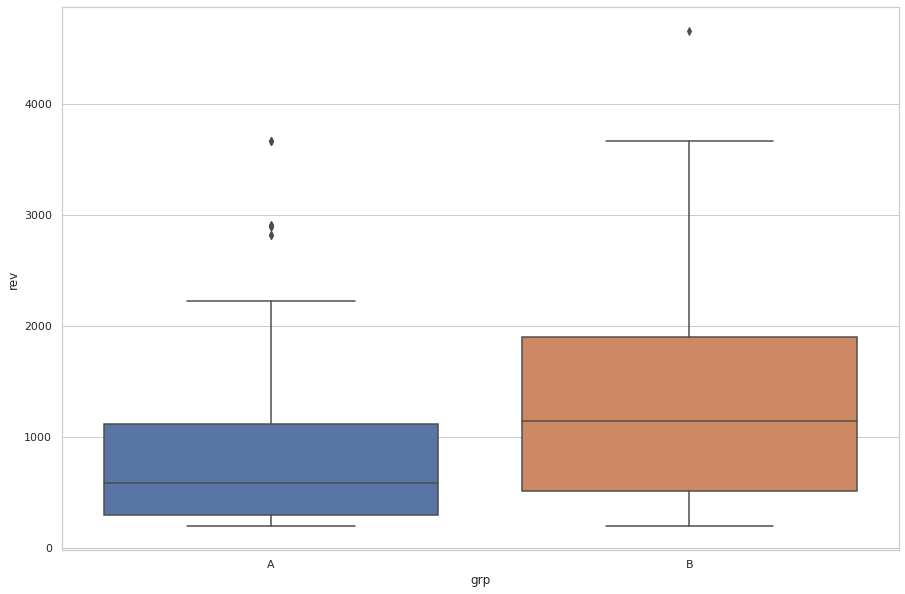

In [32]:
# Посмотрим на распределение оплат в группах

sns.boxplot(x=df_active['grp'], y=df_active['rev'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


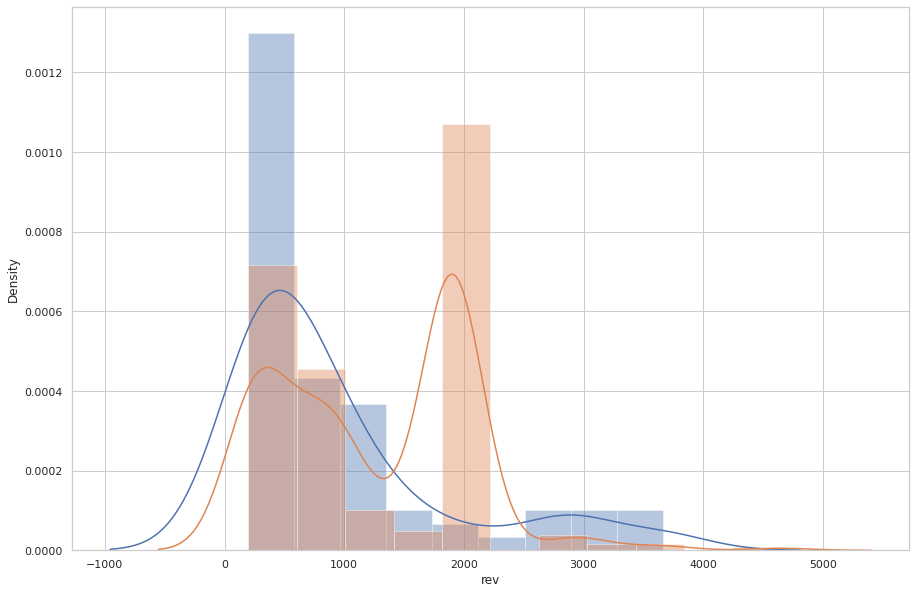

In [33]:
# Посмотрим на распределение оплат в группах

sns.distplot(df_active[df_active['grp'] == 'A'].rev)
sns.distplot(df_active[df_active['grp'] == 'B'].rev)

В группе В наблюдается существенное изменение параметров распределения - ярко выраженная бимодальность. Помимо этого t-критерий Стьюдента и u-критерий Манна-Уитни чувствительны к дисбалансу в выборках (https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes , и https://stats.stackexchange.com/questions/31326/how-should-one-interpret-the-comparison-of-means-from-different-sample-sizes/31330#31330). 

В связи с этим принимаем решение использовать bootstrap.

In [34]:
# Сплагиатим функцию с курса по статистике

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    plot = True # флаг, указывающий на необходимость вывода прогресс-бара и блока визуализации
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it), disable = not(plot)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    if plot:
        plt.hist(pd_boot_data[0], bins = 50)

        plt.style.use('ggplot')
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Проверим нулевую гипотезу об отсутствии различий между средневыборочным ARPU в группах.

In [35]:
control_arpu = df_active.query('grp == "A"')['rev'].fillna(0)
test_arpu = df_active.query('grp == "B"')['rev'].fillna(0)

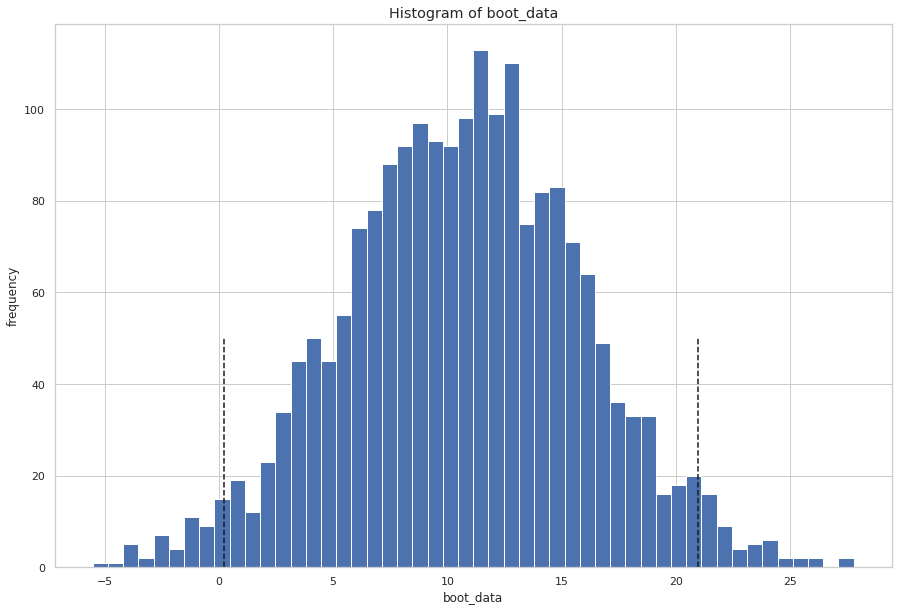

In [36]:
booted_data_arpu = get_bootstrap(test_arpu, control_arpu, boot_it=2000, statistic=np.mean)

In [37]:
booted_data_arpu['p_value']

0.039598953538180784

In [38]:
booted_data_arpu['ci']

,0
0.025,0.243963
0.975,20.959728


In [39]:
np.mean(booted_data_arpu['boot_data'])

10.691246583360284

На заданном уровне значимости (0.05) утверждаем, что наблюдаются статистически значимые различия между средневыборочным ARPU в тестовой и контрольной группе, вывод:

- ARPU в тестовой группе значимо выше в среднем на 10.8 ед. (доверительный интервал [1:20.9])

Аналогично проанализируем ARPPU

In [40]:
# ARPPU

df_active.groupby('grp').agg({'rev': 'mean'})

,rev
grp,
A,933.589744
B,1257.878992


In [41]:
control_arppu = df_active.query('grp == "A"')['rev'].dropna()
test_arppu = df_active.query('grp == "B"')['rev'].dropna()

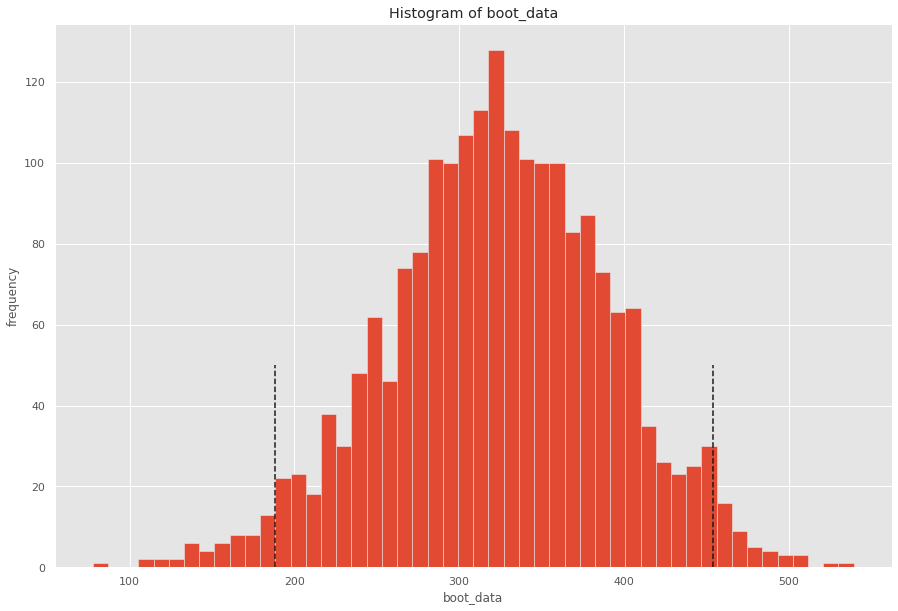

In [42]:
booted_data_arppu = get_bootstrap(test_arppu, control_arppu, boot_it=2000, statistic=np.mean)

In [43]:
booted_data_arppu['p_value']

1.3997091090849462e-06

In [44]:
booted_data_arppu['ci']

,0
0.025,188.134087
0.975,453.883688


In [45]:
np.mean(booted_data_arppu['boot_data'])

323.8955191046179

На заданном уровне значимости (0.05) утверждаем, что наблюдаются статистически значимые различия между средневыборочным ARPPU в тестовой и контрольной группе, вывод: 

- ARPPU в тестовой группе значимо выше контрольной в среднем на 324 ед. (доверительный интервал [190:455])

Так как мы имеем образовательный продукт, в котором очевидно наблюдается сезонность и различная стоимость образовательных программ, то увеличение ARPU и ARPPU может быть связано с некорректно работающим механизмом сплитования, в результате которого в тестовую группу чаще попадали студенты, покупающие более дорогие курсы. Если данные метрики важны с точки зрения дизайна эксперимента, то рекомендуется проверить систему сплитования на предмет балансировки указанных метрик.

Также возможно из-за сезонности (начало определенных курсов) наблюдается и дисбаланс в группах. В этом случае рекомендуется продлить эксперимент.

Общий вывод (с учетом ранее сделанных предположений):
1. Результаты эксперимента не могут быть приняты, так как не соблюдено корректное разбиение пользователей на группы.
2. Необходимо проверить корректность работы новой механики оплаты, так как в тестовой группе наблюдаются значения оплаты с дробной частью ".0001". Если будут внесены существенные изменения, то рекомендуется перезапустить A/B тест.
3. Не обнаружено значимого различия в конверсиях между группами.
4. ARPU и ARPPU в тестовой группе значимо увеличились.
5. В случае, если п.2 не требует перезапуска A/B теста, то рекомендуется продлить эксперимент до получения заданных параметров разбиения пользователей на группы.

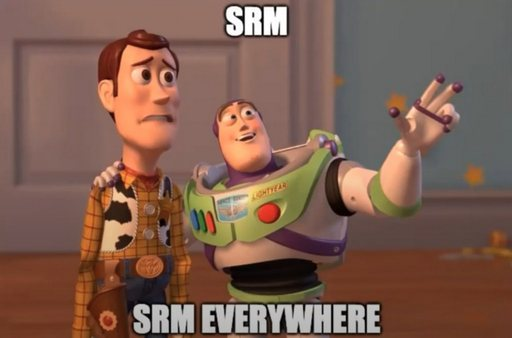

Задание 2

2.1 Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

Также в задании сделана следующая противоречивая заметка: "NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц." Противоречива она потому, что в основном тексте задания запрашивают "очень усердных", а заметка говорит об "усердных". Предполагаем, что это две разные сущности, поэтому заметку пропускаем.

In [ ]:
# -- Задание 2.1
# -- Тестировалось в redash (postgres)

# SELECT
#     count(st_id)
#     FROM
#         (
#         SELECT
#             a.st_id AS st_id,
#             max(a.sum) AS peas_count
#         FROM
#             (
#             SELECT 
#                 st_id,
#                 sum(correct) OVER w
#             FROM peas
#             where 
#                     timest >= '01/03/20 00:00' 
#                 AND timest <= '31/03/20 23:59'
#             WINDOW w AS
#                 (
#                 PARTITION BY st_id
#                 ORDER BY timest ASC
#                 RANGE BETWEEN CURRENT ROW AND '1 hour' FOLLOWING
#                 )
#             ) a
#         GROUP BY st_id
#         HAVING max(a.sum) >= 20
#         ) b

2.2 Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [ ]:
# -- Задание 2.2
# -- Тестировалось в redash (postgres)
# -- Считаем, что таблица peas содержит наблюдения за время проведения эксперимента
# -- В случае, если в peas будут лежать логи за все время, то их легко ограничить нужными датами по аналогии с предыдущим заданием, добавив в select from peas блок where с нужными датами
# -- Аналогично с покупками, считаем, что в checks данные за время эксперимента, иначе достаточно добавить в соответсвующие select'ы  блок where с нужными датами

# SELECT
#     data.test_grp,
#     SUM(data.money)/COUNT(data.st_id) AS ARPU,
#     SUM(data.money)/SUM(data.active) AS ARPAU,
#     CAST(SUM(data.converted) AS float)/CAST(COUNT(data.st_id) AS float) AS CR,
#     CAST(SUM(data.converted) AS float)/CAST(COUNT(data.active) AS float) AS CR_active,
#     CAST(SUM(data.converted_math) AS float)/CAST(COUNT(data.active_math) AS float) AS CR_math
# FROM
#     (
#     SELECT
#         studs.st_id AS st_id,
#         studs.test_grp AS test_grp,
#         checks.money AS money,
#         checks.converted AS converted,
#         peas.active AS active,
#         checks_math.converted_math converted_math,
#         peas_math.active_math AS active_math
#     FROM
#         studs AS studs
#     LEFT JOIN
#         (
#         SELECT
#             st_id,
#             SUM(money) AS money,
#             1 AS converted
#         FROM
#             checks
#         GROUP BY
#             st_id
#         ) AS checks
#     ON
#         studs.st_id = checks.st_id
#     LEFT JOIN
#         (
#         SELECT
#             DISTINCT(st_id),
#             1 AS active
#         FROM
#             peas
#         ) AS peas
#     ON
#         studs.st_id = peas.st_id
#     LEFT JOIN
#         (
#         SELECT
#             DISTINCT(st_id),
#             1 AS active_math
#         FROM
#             peas
#         WHERE
#             subject = 'math'
#         ) AS peas_math
#     ON
#         studs.st_id = peas_math.st_id
#     LEFT JOIN
#         (
#         SELECT
#             DISTINCT(st_id),
#             1 AS converted_math
#         FROM
#             checks
#         WHERE
#             subject = 'math'
#         ) AS checks_math
#     ON
#         studs.st_id = checks_math.st_id
#     ) AS data
# GROUP BY
#     data.test_grp


Задание 3

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Неоднозначная фраза в задании: "на основании дополнительных параметров пересчитывать метрики". Параметр для функции - это аргумент, который функция получает на вход. Звучит логично, чтобы после загрузки новых данных метрики всегда пересчитывались, а не только когда явно задан параметр. Поэтому будем считать, что "дополнительные параметры" - это параметры не функции, а параметры расчета метрик (число студентов в группах).

In [46]:
def group_add(
    file = 'group_add.csv',   # Файл для загрузки
    sep = ',',                # Разделитель в csv файле
    main_df = groups,         # Основной датафрейм, к которолму будем добавлять данные
    recalculate = True,       # Флаг необходимостри перерасчета метрик
    id_column = -1,           # Номер колонки с индексом
    a_part = 0.2,             # Доля группы А в эксперименте
    alpha_srm = 0.001,         # Уровень значимости для проверки на Sample Raio Mismatch
    alpha_metrics = 0.05       # Уровень значимости для проверки гипотез по метрикам
):
    
    # Проверим доступность файла
    try:
        df_groups_add = pd.read_csv(file, sep=sep)
    except FileNotFoundError:
        print('File {} not found'.format(file))
        return
    
    # Проверим корректность задания уровней значимости
    if alpha_srm > 1 or alpha_srm < 0:
        print('Error in alpha_srm. Expected value in range [0.0 : 1.0]. Aborting process.')
        return
    if alpha_metrics > 1 or alpha_metrics < 0:
        print('Error in alpha_metrics. Expected value in range [0.0 : 1.0]. Aborting process.')
        return

    # Проверим структуру файла    
    # Если колонок не 2, значит передан файл с некорректной структурой
    if df_groups_add.shape[1] != 2:             
        print('File should contain 2 columns, import aborted.')
        return
    
    df_groups_add = df_groups_add.dropna()  # Удалим пропуски в данных

    # Найдем номер колонки с id, исходя из предположения, что id имеют тип int
    # Может быть конечно в будущем id вдруг станут не int, для этого предусмотрено ручное задание номера колонки
    # в параметрах функции
    try:
        int(id_column)
    except ValueError:
        id_column = -1
        
    group_column = -1
    
    if id_column < 0 or id_column > 1:
        try:
            int(df_groups_add.loc[0][0])
            id_column = 0
            group_column = 1
        except ValueError:
            try:
                int(df_groups_add.loc[0][1])
                id_column = 1
                group_column = 0
            except ValueError:
                print('ID column not found. Should contain ID column of INT type. Import aborted.')
                return
    elif id_column == 0:
            group_column = 1
    elif id_column == 1:
            group_column = 0
    else:
        if group_column == -1:
            print('Luke, I am your father.')
        print('Unpredictable error.')
        return
    
    groups_ok = True   # Флаг проверки корректного наименования групп в наблюдениях  
    bad_values = []    # Список с некорректными значениями наименований групп
    valid_group_names = ['A', 'B', 'А', 'В', 'a', 'b', 'control', 'test']

    for group_name in df_groups_add.loc[:, df_groups_add.columns[group_column]].unique():
        if group_name not in valid_group_names:
            groups_ok = False
            bad_values.append(group_name)

    # Получим название колонки с группами
    group_column_name = df_groups_add.columns[group_column]

    if groups_ok == False:
        removed = 0               
        n = 0
        n = df_groups_add.shape[0]
        df_groups_add = df_groups_add[~df_groups_add[group_column_name].isin(bad_values)]
        removed = n - df_groups_add.shape[0]
        print('Removed {} rows with incorrect group names: {}.'.format(removed, bad_values))

    # Словарь для приведения наименования групп к единообразию (включая русские символы А и В)
    map_names = {'A': 'A', 'А': 'A', 'a': 'A', 'control': 'A', 'В': 'B', 'B': 'B', 'b': 'B', 'test': 'B'}
    df_groups_add[group_column_name] = df_groups_add[group_column_name].map(map_names)

    # Установим порядок колонок в соответствии с исходным датафреймом: [id, grp]
    df_groups_add = df_groups_add[[df_groups_add.columns[id_column], 
                                   df_groups_add.columns[group_column]]]
    
    # Установим названия колонок в соответствии с исходным датафреймом: [id, grp]
    df_groups_add.columns = main_df.columns
    
    # Соединим датафреймы и переиндексируем
    df = pd.concat([main_df, df_groups_add], ignore_index=True)
    
    # Удалим дубли, на случай если будет загружаться один и тот же файл
    df = df.drop_duplicates()
    
    # Пересчитаем метрики
    # Объединим с остальными датафреймами      
    active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
    checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')

#     active_studs = pd.read_csv('active_studs.csv')
#     checks = pd.read_csv('checks.csv', sep=';')
    
    # Возвращать будем уже объединенный датафрейм
    df_total = df.merge(active_studs, how='inner', left_on='id', right_on='student_id') \
                 .merge(checks, how='left', on='student_id') \
                 .drop(columns=['student_id'])
    df_total['converted'] = ~df_total.rev.isna()
    
    # Проверка на SRM по аналогии с 1-м заданием
    observed_studs = df_total.shape[0]
    observed = [df_total.grp.value_counts()['A'],
                df_total.grp.value_counts()['B']]
    expected = [int(round(observed_studs*a_part)), observed_studs-int(round(observed_studs*a_part))]
    pvalue_srm = chisquare(f_obs=observed, f_exp=expected)[1]
    if pvalue_srm < alpha_srm:
        print('Warning! SRM detected on significance level {}, pvalue = {}'.format(alpha_srm, pvalue_srm))
    else:
        print('No SRM detected on significance level {}, pvalue = {}'.format(alpha_srm, pvalue_srm))
            
    metrics = df_total.groupby('grp').agg({'converted': lambda x: sum(x)/len(x),
                                           'rev': [lambda x: round(sum(x.fillna(0))/len(x), 2),
                                                   lambda x: round(sum(x.dropna())/len(x.dropna()), 2)]})
    # Избавимся от лишнего уровня в названиях колонок и переименуем их
    metrics.columns = metrics.columns.get_level_values(1)
    metrics = metrics.rename(columns={'<lambda>': 'CR', '<lambda_0>': 'ARPU', '<lambda_1>': 'ARPPU'})
    metrics['SRM'] = [pvalue_srm, pvalue_srm]
    
    pvals_df = pd.DataFrame()
    if recalculate:
        # Пересчитаем CR
        p_CR = chi2_contingency(pd.crosstab(df_total.converted, df_total.grp), correction=False)[1]
            
        # Пересчитаем ARPU
        control_arpu = df_total.query('grp == "A"')['rev'].fillna(0)
        test_arpu = df_total.query('grp == "B"')['rev'].fillna(0)
        booted_data_arpu = get_bootstrap(test_arpu, control_arpu, boot_it=2000, statistic=np.mean, plot=False)
        
        # Пересчитаем ARPPU
        control_arppu = df_total.query('grp == "A"')['rev'].dropna()
        test_arppu = df_total.query('grp == "B"')['rev'].dropna()
        booted_data_arppu = get_bootstrap(test_arppu, control_arppu, boot_it=2000, statistic=np.mean, plot=False)
        
        # Вернем значения p-value по метрикам для вывода "прокрасов", не очень красиво, но пока так
        # Каждое значение - это список из p-value и разницы в метрике между группами
        # По сочетанию p-value и разницы красим ячейку в:
        # зеленый - если разница стат-значима и метрика увеличилась
        # красный - если разница стат-значима и метрика уменьшилась
        # серый - если разница не стат-значима
        pvals_df = pd.DataFrame({
            'p_value, diff': [[pvalue_srm, pvalue_srm - alpha_srm], 
                              [p_CR, metrics['CR'].loc['B'] - metrics['CR'].loc['A']], 
                              [booted_data_arpu['p_value'], metrics['ARPU'].loc['B'] - metrics['ARPU'].loc['A']], 
                              [booted_data_arppu['p_value'], metrics['ARPPU'].loc['B'] - metrics['ARPPU'].loc['A']]]},
             index=['SRM', 'CR', 'ARPU', 'ARPPU'])
        
        # Функция для реализации логики прокраса ячейки
        def apply_color(val):
            if (val[0] < alpha_metrics) and (val[1] < 0):
                color = 'red' 
            elif (val[0] < alpha_metrics) and (val[1] > 0):
                color = 'green'
            else: 
                color = 'gray'
            return 'background-color: %s' % color
        
        # Для SRM отдельная логика, так как отличается p-уровень значимости
        pvals_df = pvals_df.style.applymap(apply_color) \
            .applymap(lambda x: "background-color: red" if x[0]<alpha_srm else "background-color: green", 
                      subset=(slice('SRM')))
    
    return df, df_total, metrics, pvals_df

Проверка работы функции

In [53]:
groups_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep=';')
# groups_1 = pd.read_csv('groups.csv', sep=';')

In [54]:
df, df_total, metrics, pvals_df = group_add(main_df = groups_1)

Warning! SRM detected on significance level 0.001, pvalue = 0.0003726664655524767


In [55]:
pvals_df

,"p_value, diff"
SRM,"[0.0003726664655524767, -0.0006273335344475233]"
CR,"[0.44547028437158964, -0.004559106964780894]"
ARPU,"[0.04039704348048563, 10.71]"
ARPPU,"[1.6115159584775108e-06, 324.2900000000001]"


Функция построения графиков

In [135]:
def plot_metrics(
    df_total = df_total,
    df_metrics = metrics,
    CR = True,
    ARPU = True,
    ARPPU = True
):
    
    fig, axes = plt.subplots(2, 2)
    
    if CR:
        sns.barplot(x=metrics["grp"], y=metrics["CR"], ax=axes[0,0])
            
    if ARPU:
        sns.pointplot(x="grp", y="rev", data=df_total.fillna(0), ax=axes[0,1])
        sns.boxplot(x="grp", y="rev", data=df_total, ax=axes[1,0])
    
    if ARPPU:
        sns.pointplot(x="grp", y="rev", data=df_active, ax=axes[1,1])
    
    return 

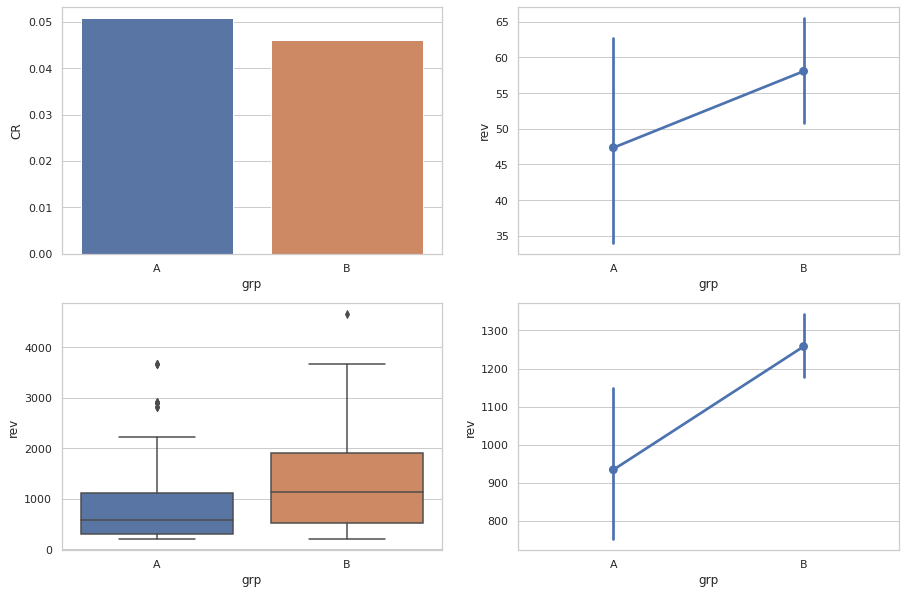

In [136]:
plot_metrics(df_total   = df_total, 
             df_metrics = metrics)